# Week 3: Build a synthesizer

<font size="6"> Laboratory 2 </font> <br>
<font size="3"> Last updated February 27, 2023 </font>

## <span style="color:orange;"> 00. Content </span>

### Mathematics 
- quantifying rounding error
- definition of the cent
- rational approximations to irrational numbers
    
### Programming Skills 
- specialized flow structures (`try`/`finally`, `for`/`else`)
- buffers
    
### Embedded Systems
- the I2S protocol
- blocking code

## <span style="color:orange;"> 0. Required Hardware </span>
- Raspberry Pi Pico
- MicroUSB cable
- Breadboard
- Jumper wires (at least 5)
- [I2S speaker module](https://learn.adafruit.com/adafruit-max98357-i2s-class-d-mono-amp), with [8-ohm speaker](https://www.adafruit.com/product/1890) connected
- [Piano keypad module](https://github.com/AldenMB/Piano_Keypad)
- Optional:
  - additional buttons and wires

<h3 style="background-color:lightblue"> Write your name and email below: </h3>

**Name:** Aidan Leib 

**Email:** pleib@purdue.edu

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## <span style="color:orange;"> 1. Intro </span>

One of the fundamental things about sounds is the timing. People are very sensitive to small differences in timing of audio signals. That is a big problem if you want to use a general-purpose computer to create or process sounds in real time, since a computer has many tasks to keep track of like monitoring network connections, checking for user input, managing file systems, moving programs into and out of working memory, health check to name a few. And those are just the things it does in the background, let alone if you ask it to do something as well! Most computers you can buy, and the smart phones today, contain specialized electronic chips for processing audio, freeing up the general-purpose parts to do other things.

Most of the complex algorithms that are performed on audio are done on DSP chips. They perform complex computations in a short amout of time. But most of them are very expensive This is where a microcontroller is an ideal choice: we get some of the flexibility of a general-purpose computer, while still being cheaper and keeping tight control over the timing of the program.

As an introduction to the tools of working with sound in real time, we will build a simple synthesizer -- that is, an electronic piano.

## <span style="color:orange;"> 2. The I2S protocol </span>

It should be no surprise that there is a special digital protocol used for audio signals. Other protocols, like I2C or SPI, simply add too much latency. The I2S protocol is much simpler than either I2C or SPI, and therefore can get much lower latency and higher data throughput. It consists of just three wires: one for a clock, one for data, and one for indicating whether the data should go to the left or right audio channel.

Today, we are going to use a module which accepts I2S input and drives a speaker directly. Wire it up as indicated in the following tables. If you are not sure you have done it correctly, then ask an instructor to verify your wiring is correct before plugging your circuit into the USB port.

| MAX 98357 | Speaker |
|-----------|---------|
| -         | (either wire) |
| +         | (the other wire) |

| MAX 98357 | Pico | What it does |
|-----------|------|--------------|
| Vin       | VBUS | USB power directly to the speaker driver |
| GND       | GND  | A shared ground           |
| BCLK      | GP16 | clock signal              |
| LRC       | GP17 | left/right channel select |
| DIN       | GP18 | data signal               |

![an image of the wiring described above](max_wiring_example_small.jpg)

Your breadboard should look something like the picture above.

### Test your circuit

Once you are sure that your circuit is wired safely, open up Thonny and run the script [circuittest.py](https://github.com/TheDataScienceLabs/DSLab_Fourier/blob/main/book/labs/synthesis/build_a_synthesizer/circuit_test.py) on your Pico. You should hear a simple tone play for two seconds, and then it should stop. If your circuit does not do this, figure out what is going wrong before you continue. Your instructor may be able to help you narrow down the problem.

Let's understand what is happening in this file, line by line.

```python
"""
This code plays a simple tone to a connected I2S speaker
for two seconds second, just to see if everything is working.
"""
```
Every good Python program should have a docstring which summarizes what the program is for.

```python
import time
from machine import I2S, Pin
```
This script only uses built-in modules, the `time` module to count out two seconds and the `machine` module to interface with hardware.

```python
tone = b'\x00\x00\x05\x08\xea\x0f\x8f\x17\xd5\x1e\x9e%\xcf+P1\t6\xe89\xde<\xdd>\xdf?\xdf?\xdd>\xde<\xe89\t6P1\xcf+\x9e%\xd5\x1e\x8f\x17\xea\x0f\x05\x08\x00\x00\xfb\xf7\x16\xf0q\xe8+\xe1b\xda1\xd4\xb0\xce\xf7\xc9\x18\xc6"\xc3#\xc1!\xc0!\xc0#\xc1"\xc3\x18\xc6\xf7\xc9\xb0\xce1\xd4b\xda+\xe1q\xe8\x16\xf0\xfb\xf7'
```
This is the data which makes up the sound we play. We will analyze this in more detail shortly.

```python
try:
    # [...]
finally:
    audio_out.deinit()
```
When an `I2S` object is created, it configures some parts of the microcontroller to run independently of the main process. It is important that these are stopped when we are done with them, even if there is an exception which makes our code stop. By using a `try`/`finally` block, we ensure that the code in the `finally` block runs no matter what.

```python
audio_out = I2S(
    0,
    sck=Pin(16),
    ws=Pin(17),
    sd=Pin(18),
    mode=I2S.TX,
    bits=16,
    format=I2S.MONO,
    rate=22_050,
    ibuf=2000,
)
```
We make a new `I2S` object, telling it which pins to connect to, to start in transmitting mode, and a few other configuration parameters.

```
starttime = time.ticks_ms()
while time.ticks_ms() < starttime + 2000:
    audio_out.write(tone)
```
We figure out the current time, in milliseconds. We continually write the data `tone` to the `I2S` device, stopping only when at least 2000 milliseconds have passed since we started.

By using built in Micropython modules, we were able to get sound with not-too-many-lines of code.

### Understanding the I2S object

When we made the `I2S` object in the example code, we told it a few things. We told it to transmit (`mode=I2S.TX`), we told it to use 16 bits for each sample (`bits=16`), we told it to use mono rather than stereo sound (`format=I2S.MONO`), and we told it to use a sample rate of 22,050 Hz (`rate=22_050`). You likely remember that most audio equipment uses a sample rate of 44,100 Hz. We use a lower sample rate because our speaker is not sensitive enough to reproduce the higher frequencies 44,100 Hz would give us, and a lower sampling rate means less work for the microcontroller. Finally, we tell the `I2S` object to make a buffer of 2000 bytes (`ibuf=2000`) to hold audio in a queue, sent out at a controlled rate of 22,050 samples (44,100 bytes) per second. In effect, that means the buffer holds

$$
2000\text{ bytes} \times \frac{1\text{ sample}}{2\text{ bytes}}\times \frac{1\text{ second}}{22,050\text{ samples}}\times\frac{1000\text{ milliseconds}}{1\text{ second}} = 45\text{ milliseconds}
$$

of audio data.


Whenever we call `audio_out.write(tone)` the `I2S` object checks whether there is enough room in the buffer to hold `tone`, which is 100 bytes long. If there is enough room, it places `tone` into the buffer. Otherwise, it sits and waits for the room to be available, then writes `tone` to the buffer.

What kind of data is `tone`, exactly? We already said it consists of 2-byte samples. Let's use `numpy` here to read it out. We will tell `numpy` to use the most common 2-byte data format, a 16 bit integer.

In [2]:
tone = b'\x00\x00\x05\x08\xea\x0f\x8f\x17\xd5\x1e\x9e%\xcf+P1\t6\xe89\xde<\xdd>\xdf?\xdf?\xdd>\xde<\xe89\t6P1\xcf+\x9e%\xd5\x1e\x8f\x17\xea\x0f\x05\x08\x00\x00\xfb\xf7\x16\xf0q\xe8+\xe1b\xda1\xd4\xb0\xce\xf7\xc9\x18\xc6"\xc3#\xc1!\xc0!\xc0#\xc1"\xc3\x18\xc6\xf7\xc9\xb0\xce1\xd4b\xda+\xe1q\xe8\x16\xf0\xfb\xf7'
samples = np.frombuffer(tone, dtype=np.int16)
print(samples)

[     0   2053   4074   6031   7893   9630  11215  12624  13833  14824
  15582  16093  16351  16351  16093  15582  14824  13833  12624  11215
   9630   7893   6031   4074   2053      0  -2053  -4074  -6031  -7893
  -9630 -11215 -12624 -13833 -14824 -15582 -16093 -16351 -16351 -16093
 -15582 -14824 -13833 -12624 -11215  -9630  -7893  -6031  -4074  -2053]


We can see that is a list of 50 integers, ranging from around -16,000 to 16,000. Let's plot them to get an idea for what it is.

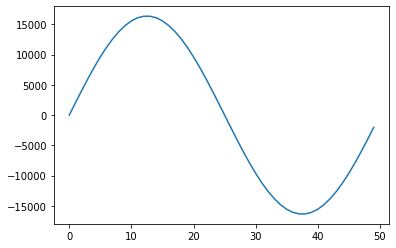

In [3]:
plt.plot(samples)
plt.show()

That looks like a clean sine wave! This one has been carefully constructed so that when it is repeated, there is a smooth transition from one sample to the next.

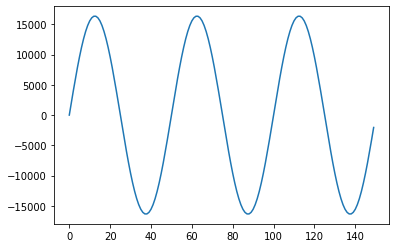

In [4]:
plt.plot(np.tile(samples, 3))
plt.show()

### <span style="color:red"> Exercise 1 </span> (20 pts)
You know that each number in `tone` is one sample, and you know the sample rate. Use this information to plot tone object given below with units of milliseconds on the x-axis. Be sure to label the x-axis in your plot with the correct units.

In [5]:
tone = b'\x00\x00\x05\x08\xea\x0f\x8f\x17\xd5\x1e\x9e%\xcf+P1\t6\xe89\xde<\xdd>\xdf?\xdf?\xdd>\xde<\xe89\t6P1\xcf+\x9e%\xd5\x1e\x8f\x17\xea\x0f\x05\x08\x00\x00\xfb\xf7\x16\xf0q\xe8+\xe1b\xda1\xd4\xb0\xce\xf7\xc9\x18\xc6"\xc3#\xc1!\xc0!\xc0#\xc1"\xc3\x18\xc6\xf7\xc9\xb0\xce1\xd4b\xda+\xe1q\xe8\x16\xf0\xfb\xf7'

What is the frequency of this sine wave? Explain in 2-3 sentences how to compute it.
<h3 style="background-color:lightblue"> Write Answers for Exercise 1 Below </h3>

Text(0.5, 0, 'Time (ms)')

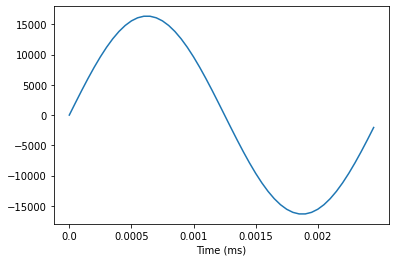

In [6]:
my_samples = np.frombuffer(tone, dtype=np.int16)
plt.plot(my_samples)
plt.xticks(
    np.arange(0, 50, step=10),
    np.arange(0, .0023, 0.0005)
)
plt.xlabel("Time (ms)")

The frequency of the tone object is 
$$f = \frac{1}{T} Hz$$ 
where 'T' is the period of the sine wave. In this,
$$T = \frac{50}{22050}$$
$$f = \frac{1}{0.0022676ms} \approx 441 Hz$$

## <span style="color:orange;"> 3. Designing good samples </span>

Remember that our goal is to make a synthesizer, so we should figure out how to make sounds of any frequency. We already know the data format we need -- just a bunch of 16 bit integers. However, there are some subtleties which we need to address. In order to make them clear, let's see what happens if we use a naive approach.

Let's make some data which gives precisely a middle F, so $440\times 2^{-1/3}$ Hz. We will start by doing an arbitrary number of samples, say, 200.

middle f has a frequency of 349.2282314330039 Hz


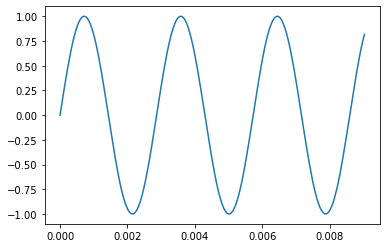

In [7]:
t = np.arange(200) / 22_050
middle_f_frequency = 440 * (2 ** (-1 / 3))
print(f'middle f has a frequency of {middle_f_frequency} Hz')
middle_f = np.sin(2 * np.pi * middle_f_frequency * t)

plt.plot(t, middle_f)
plt.show()

This is a nice sine wave, but there is a problem which comes up if we try to repeat it.

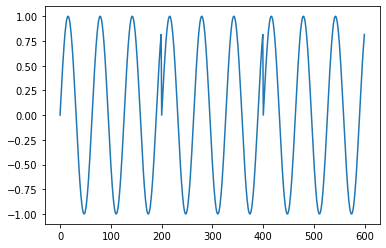

In [8]:
plt.plot(np.tile(middle_f, 3))
plt.show()

As you can see, that makes a nasty jump at every repeat. When we play this as audio, it makes a nasty buzz.

In [9]:
from IPython.display import Audio

Audio(np.tile(middle_f, 500), rate=22050)

Let's be smarter about how we choose our number of samples. Let's try and include just one period of the wave. One period is 

$$
\frac{1}{440\times 2^{-1/3} \text{ Hz}} = 2.86\text{ milliseconds}
$$

and there are 22,050 samples per second, so the ideal period is 

$$
\frac{1}{440\times 2^{-1/3} \text{ Hz}} \times \frac{22,050\text{ samples}}{1\text{ second}} = 63.14\text{ samples}
$$

Here is our first serious problem: that's not a whole number of samples. Let's hear what it sounds like if we round to the nearest number of samples.

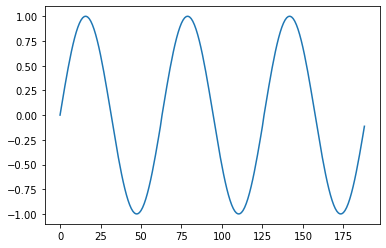

In [10]:
plt.plot(np.tile(middle_f[:63], 3))
plt.show()

Audio(np.tile(middle_f[:63], 2000), rate=22050)

That is surely a lot better, but if you look closely at the graph you can still see a jump, and if you listen closely you can still hear a buzz.

The solution is to be less picky about our frequency. We wanted something with exactly $440\times 2^{-1/3}$ Hz, but nobody's ears could tell if it were off by a little bit. Instead of choosing the number of samples from the frequency, what if we choose a frequency from the number of samples? If we do a sound with exactly 63 samples per second, what frequency would that be? Simply

$$
\frac{1}{63\text{ samples}}\times \frac{22,050 \text{ samples}}{\text{second}} = 350\text{ Hz},
$$

which is pretty close to  $440\times 2^{-1/3} = 349.2$ Hz. Hear the difference for yourself. The buzzing is gone, but the pitch is slightly different. It is very close, so you may not be able to quite make it out.

In [11]:
t = np.arange(30_000)/22_050
true_f = np.sin(2*np.pi*middle_f_frequency*t)
Audio(true_f, rate=22050)

In [12]:
approximate_f = np.tile(np.sin(np.linspace(0, 2*np.pi, 63, endpoint=False)), 500)
Audio(approximate_f, rate=22050)

### Cents for errors in frequency

We found the 63-sample approximation is off by 0.8 Hz from the true frequency. How big of a deal is that? For discussing small differences in frequency, we usually use the unit called the **cent**. Each note on the keyboard is separated by 100 cents, hence the name. Since the notes are defined by ratios, so are cents.

The difference in frequency between two frequencies $a$ and $b$ is defined to be 

$$
n=1200\log_2 \frac{b}{a}.
$$

So, in our example, the approximation 350 Hz is 

$$
1200\log_2 \frac{350}{440\times 2^{-1/3}} = 3.82\text{ cents}
$$

higher than a true middle F. People generally have a hard time distinguishing between notes which are within about 10 cents, though some people can notice differences of about 5 cents. That tells us that our approximation is certainly good enough.

### Summary thus far

We noticed that, in order to have a repeating audio clip which gives the exactly correct frequency for a given note, we would have jumps in between repeats which make a nasty buzzing sound. In order to get rid of the buzzing, we can change the frequency a little bit to make an audio clip with a nearby frequency which does not buzz but is off by a little bit. In the case of middle F, the true note has a frequency of 349.2 Hz, which we can approximate with a clip of 63 samples which has a frequency of 350 Hz.

### Troublesome notes

In a way we got lucky with middle F, because we found a true F has 63.14 samples/cycle which is very close to 63 samples/cycle. With some notes we are not so lucky. Consider, for example, middle B. This has a frequency of $440\times 2^{1/6}=493.9$ Hz. That means having 

$$
\frac{22,050 \text{ samples}}{\text{second}}\times\frac{1}{440\times 2^{1/6}} = 44.65\text{ samples}
$$

in each cycle. We could have to round that pretty far to get to 45 samples. As a result, a rounded clip which repeats every 45 samples would have a frequency of 

$$
\frac{22,050\text{ samples}}{\text{second}}\times\frac{1}{45\text{ samples}} = 490\text{ Hz},
$$

which is 

$$
1200\log_2\frac{490}{493.9} = -13.7\text{ cents}
$$

off from the true frequency. That is easily audible, and a bit of a problem. How can we fix it?

44.65 is far from either 44 or 45, but it is pretty close to $44+\frac{2}{3}$. If we had a clip that was $3\times(44+\frac{2}{3})=134$ samples long, we could put three cycles of the note into our audio clip. That would give us a frequency of 

$$
\frac{3\text{ cycles}}{134\text{ samples}}\times \frac{22,050\text{ samples}}{\text{second}}= 493.6 \text{ Hz}.
$$

That is much closer to the true value, only off by 0.79 cents.

### The rest of them

We can use `pandas` to easily make a table of the frequencies from middle B to middle C. We can see just how good (or how bad) the simplest approximation (rounding to the nearest number of samples per audio clip) is.

In [13]:
import pandas as pd

notes = "C C# D D# E F F# G G# A A# B"
scale = pd.Series(440*2**((np.arange(12)-9)/12), index = notes.split())
samples_per_cycle = 22050/scale
rounded = np.rint(samples_per_cycle).astype(int)
approximation = 22050/rounded
errors = 1200*np.log2(approximation/scale)

summary = pd.DataFrame({
    'Correct frequency': scale,
    'Samples per cycle': samples_per_cycle,
    'Rounded': rounded,
    'Approximation frequency': approximation,
    'Difference (cents)': errors,
})
summary

,Correct frequency,Samples per cycle,Rounded,Approximation frequency,Difference (cents)
C,261.625565,84.280754,84,262.500000,5.776679
C#,277.182631,79.550439,80,275.625000,-9.756128
D,293.664768,75.085616,75,294.000000,1.975158
D#,311.126984,70.871384,71,310.563380,-3.138957
E,329.627557,66.893679,67,329.104478,-2.749442
F,349.228231,63.139225,63,350.000000,3.821678
F#,369.994423,59.595493,60,367.500000,-11.711129
G,391.995436,56.250655,56,393.750000,7.731680
G#,415.304698,53.093548,53,416.037736,3.053041
A,440.000000,50.113636,50,441.000000,3.930158


### <span style="color:red"> Exercise 2 </span> (30 pts)
Six of the notes above are off by more than 5 cents from the correct frequency, when you just round to the nearest number of samples per cycle. We showed how you can make an audio clip with more cycles to get a better approximation. Use that same strategy to find a number of samples which approximates every note above, with an error of less than 5 cents.
<h3 style="background-color:lightblue"> Write Answers for Exercise 2 Below </h3>

In [14]:
bad_estimates = summary[np.abs(summary['Difference (cents)']) > 5].copy()
nums = np.array([1,1,2,1,1,2])
denoms = np.array([3,2,3,4,3,3])
bad_estimates['Friendly Cycles'] = denoms / nums * nums
# bad_estimates.loc['F#', 'Friendly Cycles'] *= 2
# bad_estimates.loc['B', 'Friendly Cycles'] *= 2
bad_estimates['Rounded'] = np.floor(bad_estimates['Samples per cycle'])
num_samples = bad_estimates['Friendly Cycles'] * (bad_estimates['Rounded'] + nums / bad_estimates['Friendly Cycles'])
bad_estimates['Approximation frequency'] = bad_estimates['Friendly Cycles'] / num_samples * 22050
bad_estimates['Difference (cents)'] = errors = 1200*np.log2(bad_estimates['Approximation frequency']/bad_estimates['Correct frequency'])
bad_estimates

,Correct frequency,Samples per cycle,Rounded,Approximation frequency,Difference (cents),Friendly Cycles
C,261.625565,84.280754,84.0,261.462451,-1.079703,3.0
C#,277.182631,79.550439,79.0,277.358491,1.098040,2.0
F#,369.994423,59.595493,59.0,369.553073,-2.066346,3.0
G,391.995436,56.250655,56.0,392.000000,0.020157,4.0
A#,466.163762,47.300974,47.0,465.845070,-1.183956,3.0
B,493.883301,44.646174,44.0,493.656716,-0.794442,3.0


## <span style="color:orange;"> 4. The completed synthesizer </span>

Now that we know how many samples to use for each note, we can have the microcontroller play them when we press buttons. In order to make it easier to wire up a keypad worth of buttons, a module has been provided which simply connects 12 buttons to 12 GPIO pins on the Pico, connecting the pins to ground whenever the corresponding button is pressed. You could just as well have wired up 12 buttons individually yourself, but this module makes it all tidier.

Connect the module to GPIO pins 4-15, as in the picture below.

![a picture showing how to connect the keypad module](with_keypad_module_small.jpg)

Then, load up the script [synth.py](https://github.com/TheDataScienceLabs/DSLab_Fourier/blob/main/book/labs/synthesis/build_a_synthesizer/synth.py) and load it in Thonny. When running it, you should find that you have a synthesizer, though it only plays the notes F and B.

Those are also the only two entries in the dictionary `tones` which are not `silence`. In Exercise 3 you will have to create audio clips to fill in the other entries. First, let's see how the rest of the script works, and how the example tones were generated.

### The script

Let's go through this script line by line.

```python
"""
This is the driver code for a synthsizer.
"""
from machine import I2S, Pin
```
Every good Python file has a docstring. The only modules we are using are built in.

```python
keys = {
    letter: Pin(i, Pin.IN, Pin.PULL_UP)
    for i, letter in zip(range(4, 16), "C C# D D# E F F# G G# A A# B".split())
}
```

This is a dictionary comprehension, a short way of writing a dictionary. The dictionary keys are letters (names of notes) and the values are pins. We configure the pins to use pull up resistors, so that when a button connects the corresponding pin to ground, the voltage changes.

```python
silence = bytes(100)
```
This makes a byte string of all zeros:

In [15]:
bytes(100)

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

This would be interpreted by the I2S object as 50 samples of zero, which is 2.3 milliseconds of silence.

```python
tones = {
    #[...]
}
```
This is the dictionary which holds the audio clips. We will explore how these are made in a bit.

```python
try:
    audio_out = I2S(
        # ...
    )

    while True:
        # ...
finally:
    audio_out.deinit()
```
The I2S object is configured in exactly the same way as in the previous example. The `try`/`finally` block is extra important here, because we are using a `while True` loop. The only way we will get out of that loop is if an exception is raised, and we want to be sure that `audio_out.deinit()` is called no matter what.

```python
for letter, pin in keys.items():
    if not pin.value():
        audio_out.write(tones[letter])
        break
else:
    audio_out.write(silence)
```
Here we are using a somewhat uncommon structure, the `for`/`else` block. Notice that the `else` is not connected to the `if`, it's connected to the `for`. The way this work is that the code in the `else` block only runs if the `for` loop does not end with a `break`. That is, a `break` statement would exit the for loop and skip the `else` block but if the `for` loop gets all the way through without a `break` then the `else` block runs.

The effect here is that the first pin we find pressed will get its corresponding tone written to the speaker buffer, and then we leave the loop. If we don't find any button pressed, then we enter the `else` block and write 2.3 milliseconds of silence to the buffer instead.

Since this is in a loop, it will immediately run again and again, so we get a near-instant response when the buttons change.

### Making the clips

The byte strings in the `tones` dictionary were made using the following code, then copy/pasted into [synth.py](https://github.com/TheDataScienceLabs/DSLab_Fourier/blob/main/book/labs/synthesis/build_a_synthesizer/synth.py).

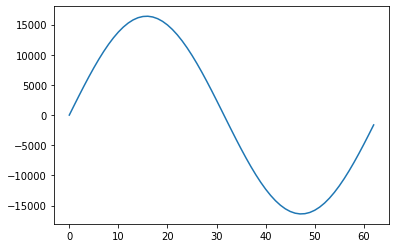

b'\x00\x00_\x06\xae\x0c\xdd\x12\xdc\x18\x9b\x1e\r$#)\xd0-\t2\xc25\xf38\x93;\x9b=\x07?\xd2?\xfa?\x80?e>\xaa<V:l7\xf63\xfc/\x87+\xa4&_!\xc4\x1b\xe3\x15\xca\x0f\x89\t0\x03\xd0\xfcw\xf66\xf0\x1d\xea<\xe4\xa1\xde\\\xd9y\xd4\x04\xd0\n\xcc\x94\xc8\xaa\xc5V\xc3\x9b\xc1\x80\xc0\x06\xc0.\xc0\xf9\xc0e\xc2m\xc4\r\xc7>\xca\xf7\xcd0\xd2\xdd\xd6\xf3\xdbe\xe1$\xe7#\xedR\xf3\xa1\xf9'


In [16]:
f = 2**14*np.sin(np.linspace(0, 2*np.pi, 63, endpoint=False))
plt.plot(f)
plt.show()
print(f.astype(np.int16).tobytes())

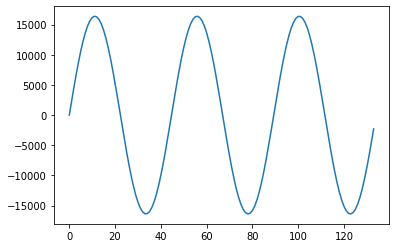

b'\x00\x00\xf9\x08\xc4\x116\x1a$"d)\xd3/Q5\xc19\x0c=#?\xfb?\x8f?\xe2=\xfb:\xeb6\xc41\xa2+\xa3$\xeb\x1c\xa1\x14\xee\x0b\xff\x02\x02\xfa"\xf1\x8e\xe8p\xe0\xf1\xd88\xd2g\xcc\x9a\xc7\xeb\xc3l\xc1)\xc0)\xc0l\xc1\xeb\xc3\x9a\xc7g\xcc8\xd2\xf1\xd8p\xe0\x8e\xe8"\xf1\x02\xfa\xff\x02\xee\x0b\xa1\x14\xeb\x1c\xa3$\xa2+\xc41\xeb6\xfb:\xe2=\x8f?\xfb?#?\x0c=\xc19Q5\xd3/d)$"6\x1a\xc4\x11\xf9\x08\x00\x00\x07\xf7<\xee\xca\xe5\xdc\xdd\x9c\xd6-\xd0\xaf\xca?\xc6\xf4\xc2\xdd\xc0\x05\xc0q\xc0\x1e\xc2\x05\xc5\x15\xc9<\xce^\xd4]\xdb\x15\xe3_\xeb\x12\xf4\x01\xfd\xfe\x05\xde\x0er\x17\x90\x1f\x0f\'\xc8-\x993f8\x15<\x94>\xd7?\xd7?\x94>\x15<f8\x993\xc8-\x0f\'\x90\x1fr\x17\xde\x0e\xfe\x05\x01\xfd\x12\xf4_\xeb\x15\xe3]\xdb^\xd4<\xce\x15\xc9\x05\xc5\x1e\xc2q\xc0\x05\xc0\xdd\xc0\xf4\xc2?\xc6\xaf\xca-\xd0\x9c\xd6\xdc\xdd\xca\xe5<\xee\x07\xf7'


In [17]:
b = 2**14*np.sin(np.linspace(0, 6*np.pi, 134, endpoint=False))
plt.plot(b)
plt.show()
print(b.astype(np.int16).tobytes())

A couple things to notice about how these clips were generated:

1. Each of the arrays is multiplied by `2**14`, so that when they are written as integers they don't all just round to zero. In I2S, the magnitude corresponds to the volume, with $2^{15}$ being the loudest possible signal (that's the largest number you can have in a 16 bit integer, since one bit handles sign).
2. Since we know exactly how many samples we want in each clip, we can specify that directly rather than having to compute a frequency.
3. By using the flag `endpoint=False` we ensure that the signal will repeat nicely. In effect, the endpoint for one cycle is the start of the next cycle -- there is no reason to include it twice.

### <span style="color:red"> Exercise 3 </span> (30 pts)
Use the sample counts you found in exercise 2 to make byte strings for the other notes. Copy them into [synth.py](https://github.com/TheDataScienceLabs/DSLab_Fourier/blob/main/book/labs/synthesis/build_a_synthesizer/synth.py), and enjoy your completed synthesizer!
<h3 style="background-color:lightblue"> Write Answers for Exercise 3 Below </h3>

Wave and bytes for C:
b"\x00\x00\xc8\x04\x89\t=\x0e\xdd\x12a\x17\xc4\x1b\x00 \r$\xe7'\x87+\xea.\t2\xe14l7\xa99\x93;(=e>I?\xd2?\x00@\xd2?I?e>(=\x93;\xa99l7\xe14\t2\xea.\x87+\xe7'\r$\xff\x1f\xc4\x1ba\x17\xdd\x12=\x0e\x89\t\xc8\x04\x00\x008\xfbw\xf6\xc3\xf1#\xed\x9f\xe8<\xe4\x00\xe0\xf3\xdb\x19\xd8y\xd4\x16\xd1\xf7\xcd\x1f\xcb\x94\xc8W\xc6m\xc4\xd8\xc2\x9b\xc1\xb7\xc0.\xc0\x00\xc0.\xc0\xb7\xc0\x9b\xc1\xd8\xc2m\xc4W\xc6\x94\xc8\x1f\xcb\xf7\xcd\x16\xd1y\xd4\x19\xd8\xf3\xdb\x01\xe0<\xe4\x9f\xe8#\xed\xc3\xf1w\xf68\xfb\x00\x00\xc8\x04\x89\t=\x0e\xdd\x12a\x17\xc4\x1b\x00 \r$\xe7'\x87+\xea.\t2\xe14l7\xa99\x93;(=e>I?\xd2?\x00@\xd2?I?e>(=\x93;\xa99l7\xe14\t2\xea.\x87+\xe7'\r$\xff\x1f\xc4\x1ba\x17\xdd\x12=\x0e\x89\t\xc8\x04\x00\x008\xfbw\xf6\xc3\xf1#\xed\x9f\xe8<\xe4\x00\xe0\xf3\xdb\x19\xd8y\xd4\x16\xd1\xf7\xcd\x1f\xcb\x94\xc8W\xc6m\xc4\xd8\xc2\x9b\xc1\xb7\xc0.\xc0\x00\xc0.\xc0\xb7\xc0\x9b\xc1\xd8\xc2m\xc4W\xc6\x94\xc8\x1f\xcb\xf7\xcd\x16\xd1y\xd4\x19\xd8\xf3\xdb\x01\xe0<\xe4\x9f\xe8#\xed\xc3\xf1w\

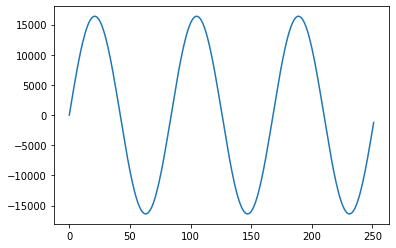

Wave and bytes for C#:
b'\x00\x00\x15\x05#\n \x0f\x04\x14\xc9\x18e\x1d\xd1!\x07&\xff)\xb3-\x1e184\xff6l9|;,=y>a?\xe2?\xfc?\xaf?\xfa>\xdf=`<\x80:A8\xa65\xb52r/\xe2+\x0b(\xf3#\xa1\x1f\x1c\x1bk\x16\x96\x11\xa4\x0c\x9d\x07\x8b\x02u\xfdc\xf8\\\xf3j\xee\x95\xe9\xe4\xe4_\xe0\r\xdc\xf5\xd7\x1e\xd4\x8e\xd0K\xcdZ\xca\xbf\xc7\x80\xc5\xa0\xc3!\xc2\x06\xc1Q\xc0\x04\xc0\x1e\xc0\x9f\xc0\x87\xc1\xd4\xc2\x84\xc4\x94\xc6\x01\xc9\xc8\xcb\xe2\xceM\xd2\x01\xd6\xf9\xd9/\xde\x9b\xe27\xe7\xfc\xeb\xe0\xf0\xdd\xf5\xeb\xfa\x00\x00\x15\x05#\n \x0f\x04\x14\xc9\x18e\x1d\xd1!\x07&\xff)\xb3-\x1e184\xff6l9|;,=y>a?\xe2?\xfc?\xaf?\xfa>\xdf=`<\x80:A8\xa65\xb52r/\xe2+\x0b(\xf3#\xa1\x1f\x1c\x1bk\x16\x96\x11\xa4\x0c\x9d\x07\x8b\x02u\xfdc\xf8\\\xf3j\xee\x95\xe9\xe4\xe4_\xe0\r\xdc\xf5\xd7\x1e\xd4\x8e\xd0K\xcdZ\xca\xbf\xc7\x80\xc5\xa0\xc3!\xc2\x06\xc1Q\xc0\x04\xc0\x1e\xc0\x9f\xc0\x87\xc1\xd4\xc2\x84\xc4\x94\xc6\x01\xc9\xc8\xcb\xe2\xceM\xd2\x01\xd6\xf9\xd9/\xde\x9b\xe27\xe7\xfc\xeb\xe0\xf0\xdd\xf5\xeb\xfa'


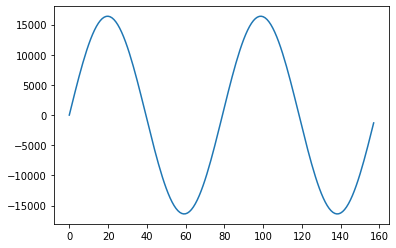

Wave and bytes for D:
b'\x00\x00Z\x05\xac\n\xea\x0f\x0c\x15\x07\x1a\xd5\x1ej#\xc0\'\xcf+\x8f/\xfa2\t6\xb78\xff:\xde<O>P?\xdf?\xfc?\xa6?\xdd>\xa4=\xfc;\xe89l7\x8d4P1\xb9-\xd1)\x9e%\'!t\x1c\x8f\x17\x7f\x12N\r\x05\x08\xae\x02R\xfd\xfb\xf7\xb2\xf2\x81\xedq\xe8\x8c\xe3\xd9\xdeb\xda/\xd6G\xd2\xb0\xces\xcb\x94\xc8\x18\xc6\x04\xc4\\\xc2#\xc1Z\xc0\x04\xc0!\xc0\xb0\xc0\xb1\xc1"\xc3\x01\xc5I\xc7\xf7\xc9\x06\xcdq\xd01\xd4@\xd8\x96\xdc+\xe1\xf9\xe5\xf4\xea\x16\xf0T\xf5\xa6\xfa'


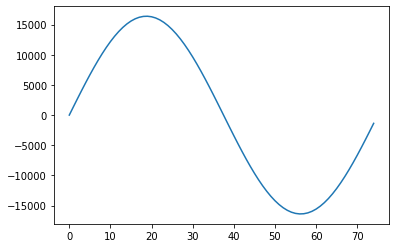

Wave and bytes for D#:
b'\x00\x00\xa8\x05D\x0b\xca\x10/\x16g\x1bh (%\x9e)\xc0-\x871\xea4\xe47m:\x82<\x1d>;?\xdb?\xfb?\x9b?\xbc>_=\x86;79u6E3\xaf/\xba+m\'\xd1"\xef\x1d\xd1\x18\x81\x13\x0b\x0ex\x08\xd4\x02,\xfd\x88\xf7\xf5\xf1\x7f\xec/\xe7\x11\xe2/\xdd\x93\xd8F\xd4Q\xd0\xbb\xcc\x8b\xc9\xc9\xc6z\xc4\xa1\xc2D\xc1e\xc0\x05\xc0%\xc0\xc5\xc0\xe3\xc1~\xc3\x93\xc5\x1c\xc8\x16\xcby\xce@\xd2b\xd6\xd8\xda\x98\xdf\x99\xe4\xd1\xe96\xef\xbc\xf4X\xfa'


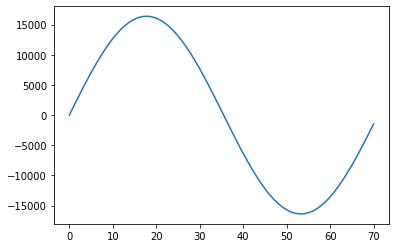

Wave and bytes for E:
b'\x00\x00\xfe\x05\xee\x0b\xc4\x11r\x17\xeb\x1c$"\x0f\'\xa2+\xd3/\x993\xeb6\xc19\x15<\xe2=#?\xd7?\xfb?\x8f?\x94>\x0c=\xfb:f8Q5\xc41\xc8-d)\xa3$\x90\x1f6\x1a\xa1\x14\xde\x0e\xf9\x08\xff\x02\x01\xfd\x07\xf7"\xf1_\xeb\xca\xe5p\xe0]\xdb\x9c\xd68\xd2<\xce\xaf\xca\x9a\xc7\x05\xc5\xf4\xc2l\xc1q\xc0\x05\xc0)\xc0\xdd\xc0\x1e\xc2\xeb\xc3?\xc6\x15\xc9g\xcc-\xd0^\xd4\xf1\xd8\xdc\xdd\x15\xe3\x8e\xe8<\xee\x12\xf4\x02\xfa'


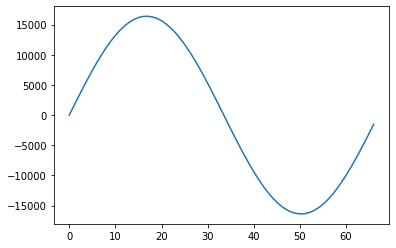

Wave and bytes for F:
b'\x00\x00_\x06\xae\x0c\xdd\x12\xdc\x18\x9b\x1e\r$#)\xd0-\t2\xc25\xf38\x93;\x9b=\x07?\xd2?\xfa?\x80?e>\xaa<V:l7\xf63\xfc/\x87+\xa4&_!\xc4\x1b\xe3\x15\xca\x0f\x89\t0\x03\xd0\xfcw\xf66\xf0\x1d\xea<\xe4\xa1\xde\\\xd9y\xd4\x04\xd0\n\xcc\x94\xc8\xaa\xc5V\xc3\x9b\xc1\x80\xc0\x06\xc0.\xc0\xf9\xc0e\xc2m\xc4\r\xc7>\xca\xf7\xcd0\xd2\xdd\xd6\xf3\xdbe\xe1$\xe7#\xedR\xf3\xa1\xf9'


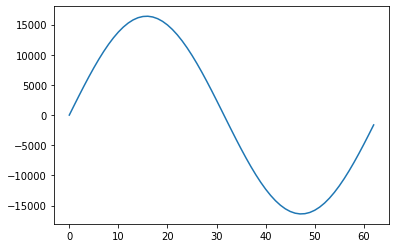

Wave and bytes for F#:
b'\x00\x00\xcd\x06\x87\r\x19\x14r\x1a} *&i+*0_4\xfc7\xf6:F=\xe4>\xcb?\xfa?o?+>4<\x8e9A6V2\xda-\xd8(a#\x82\x1dN\x17\xd6\x10.\ng\x03\x99\xfc\xd2\xf5*\xef\xb2\xe8~\xe2\x9f\xdc(\xd7&\xd2\xaa\xcd\xbf\xc9r\xc6\xcc\xc3\xd5\xc1\x91\xc0\x06\xc05\xc0\x1c\xc1\xba\xc2\n\xc5\x04\xc8\xa1\xcb\xd6\xcf\x97\xd4\xd6\xd9\x83\xdf\x8e\xe5\xe7\xeby\xf23\xf9\x00\x00\xcd\x06\x87\r\x19\x14r\x1a} *&i+*0_4\xfc7\xf6:F=\xe4>\xcb?\xfa?o?+>4<\x8e9A6V2\xda-\xd8(a#\x82\x1dN\x17\xd6\x10.\ng\x03\x99\xfc\xd2\xf5*\xef\xb2\xe8~\xe2\x9f\xdc(\xd7&\xd2\xaa\xcd\xbf\xc9r\xc6\xcc\xc3\xd5\xc1\x91\xc0\x06\xc05\xc0\x1c\xc1\xba\xc2\n\xc5\x04\xc8\xa1\xcb\xd6\xcf\x97\xd4\xd6\xd9\x83\xdf\x8e\xe5\xe7\xeby\xf23\xf9\x00\x00\xcd\x06\x87\r\x19\x14r\x1a} *&i+*0_4\xfc7\xf6:F=\xe4>\xcb?\xfa?o?+>4<\x8e9A6V2\xda-\xd8(a#\x82\x1dN\x17\xd6\x10.\ng\x03\x99\xfc\xd2\xf5*\xef\xb2\xe8~\xe2\x9f\xdc(\xd7&\xd2\xaa\xcd\xbf\xc9r\xc6\xcc\xc3\xd5\xc1\x91\xc0\x06\xc05\xc0\x1c\xc1\xba\xc2\n\xc5\x04\xc8\xa1\xcb\xd6\xcf\x97\xd4\xd6\xd9\x83\xd

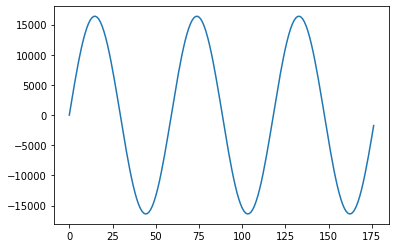

Wave and bytes for G:
b'\x00\x00*\x07=\x0e#\x15\xc4\x1b\x0c"\xe7\'A-\t206\xa99h<e>\x98?\x00@\x98?e>h<\xa9906\t2A-\xe7\'\x0c"\xc4\x1b#\x15=\x0e*\x07\x00\x00\xd6\xf8\xc3\xf1\xdd\xea<\xe4\xf4\xdd\x19\xd8\xbf\xd2\xf7\xcd\xd0\xc9W\xc6\x98\xc3\x9b\xc1h\xc0\x00\xc0h\xc0\x9b\xc1\x98\xc3W\xc6\xd0\xc9\xf7\xcd\xbf\xd2\x19\xd8\xf4\xdd<\xe4\xdd\xea\xc3\xf1\xd6\xf8\x00\x00*\x07=\x0e#\x15\xc4\x1b\x0c"\xe7\'A-\t206\xa99h<e>\x98?\x00@\x98?e>h<\xa9906\t2A-\xe7\'\x0c"\xc4\x1b#\x15=\x0e*\x07\x00\x00\xd6\xf8\xc3\xf1\xdd\xea<\xe4\xf4\xdd\x19\xd8\xbf\xd2\xf7\xcd\xd0\xc9W\xc6\x98\xc3\x9b\xc1h\xc0\x00\xc0h\xc0\x9b\xc1\x98\xc3W\xc6\xd0\xc9\xf7\xcd\xbf\xd2\x19\xd8\xf4\xdd<\xe4\xdd\xea\xc3\xf1\xd6\xf8\x00\x00*\x07=\x0e#\x15\xc4\x1b\x0c"\xe7\'A-\t206\xa99h<e>\x98?\x00@\x98?e>h<\xa9906\t2A-\xe7\'\x0c"\xc4\x1b#\x15=\x0e*\x07\x00\x00\xd6\xf8\xc3\xf1\xdd\xea<\xe4\xf4\xdd\x19\xd8\xbf\xd2\xf7\xcd\xd0\xc9W\xc6\x98\xc3\x9b\xc1h\xc0\x00\xc0h\xc0\x9b\xc1\x98\xc3W\xc6\xd0\xc9\xf7\xcd\xbf\xd2\x19\xd8\xf4\xdd<\xe4\xdd\xea\xc3\

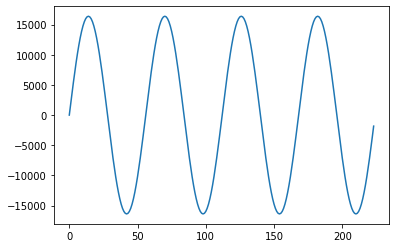

Wave and bytes for G#:
b'\x00\x00\x91\x07\x08\x0fH\x169\x1d\xc0#\xc7)8/\xff3\x0c8N;\xbc=L?\xf8?\xbf?\xa0>\xa0<\xc79\x1e6\xb21\x94,\xd5&\x8b \xcc\x19\xb1\x12R\x0b\xca\x036\xfc\xae\xf4O\xed4\xe6u\xdf+\xd9l\xd3N\xce\xe2\xc99\xc6`\xc3`\xc1A\xc0\x08\xc0\xb4\xc0D\xc2\xb2\xc4\xf4\xc7\x01\xcc\xc8\xd09\xd6@\xdc\xc7\xe2\xb8\xe9\xf8\xf0o\xf8'


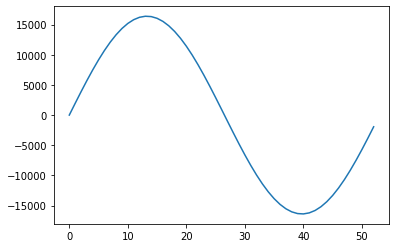

Wave and bytes for A:
b'\x00\x00\x05\x08\xea\x0f\x8f\x17\xd5\x1e\x9e%\xcf+P1\t6\xe89\xde<\xdd>\xdf?\xdf?\xdd>\xde<\xe89\t6P1\xcf+\x9e%\xd5\x1e\x8f\x17\xea\x0f\x05\x08\x00\x00\xfb\xf7\x16\xf0q\xe8+\xe1b\xda1\xd4\xb0\xce\xf7\xc9\x18\xc6"\xc3#\xc1!\xc0!\xc0#\xc1"\xc3\x18\xc6\xf7\xc9\xb0\xce1\xd4b\xda+\xe1q\xe8\x16\xf0\xfb\xf7'


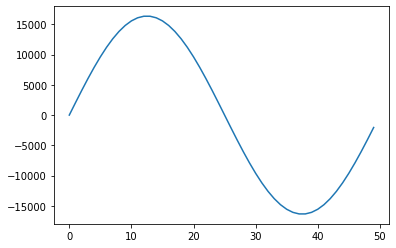

Wave and bytes for A#:
b"\x00\x00\x87\x08\xe8\x10\xfc\x18\x9d \xa9'\x01.\x863\x1f8\xb9;A>\xad?\xf6?\x1b? =\r:\xf15\xdf0\xee*8$\xdd\x1c\xfe\x14\xbf\x0cF\x04\xba\xfbA\xf3\x02\xeb#\xe3\xc8\xdb\x12\xd5!\xcf\x0f\xca\xf3\xc5\xe0\xc2\xe5\xc0\n\xc0S\xc0\xbf\xc1G\xc4\xe1\xc7z\xcc\xff\xd1W\xd8c\xdf\x04\xe7\x18\xefy\xf7\x00\x00\x87\x08\xe8\x10\xfc\x18\x9d \xa9'\x01.\x863\x1f8\xb9;A>\xad?\xf6?\x1b? =\r:\xf15\xdf0\xee*8$\xdd\x1c\xfe\x14\xbf\x0cF\x04\xba\xfbA\xf3\x02\xeb#\xe3\xc8\xdb\x12\xd5!\xcf\x0f\xca\xf3\xc5\xe0\xc2\xe5\xc0\n\xc0S\xc0\xbf\xc1G\xc4\xe1\xc7z\xcc\xff\xd1W\xd8c\xdf\x04\xe7\x18\xefy\xf7\x00\x00\x87\x08\xe8\x10\xfc\x18\x9d \xa9'\x01.\x863\x1f8\xb9;A>\xad?\xf6?\x1b? =\r:\xf15\xdf0\xee*8$\xdd\x1c\xfe\x14\xbf\x0cF\x04\xba\xfbA\xf3\x02\xeb#\xe3\xc8\xdb\x12\xd5!\xcf\x0f\xca\xf3\xc5\xe0\xc2\xe5\xc0\n\xc0S\xc0\xbf\xc1G\xc4\xe1\xc7z\xcc\xff\xd1W\xd8c\xdf\x04\xe7\x18\xefy\xf7"


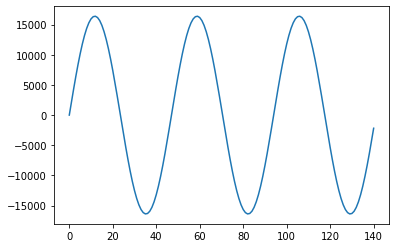

Wave and bytes for B:
b'\x00\x00\x1b\t\x07\x12\x96\x1a\x99"\xe9)^0\xd757:h=Y?\x00@Y?h=7:\xd75^0\xe9)\x99"\x96\x1a\x07\x12\x1b\t\x00\x00\xe5\xf6\xf9\xedj\xe5g\xdd\x17\xd6\xa2\xcf)\xca\xc9\xc5\x98\xc2\xa7\xc0\x00\xc0\xa7\xc0\x98\xc2\xc9\xc5)\xca\xa2\xcf\x17\xd6g\xddj\xe5\xf9\xed\xe5\xf6\x00\x00\x1b\t\x07\x12\x96\x1a\x99"\xe9)^0\xd757:h=Y?\x00@Y?h=7:\xd75^0\xe9)\x99"\x96\x1a\x07\x12\x1b\t\x00\x00\xe5\xf6\xf9\xedj\xe5g\xdd\x17\xd6\xa2\xcf)\xca\xc9\xc5\x98\xc2\xa7\xc0\x00\xc0\xa7\xc0\x98\xc2\xc9\xc5)\xca\xa2\xcf\x17\xd6g\xddj\xe5\xf9\xed\xe5\xf6\x00\x00\x1b\t\x07\x12\x96\x1a\x99"\xe9)^0\xd757:h=Y?\x00@Y?h=7:\xd75^0\xe9)\x99"\x96\x1a\x07\x12\x1b\t\x00\x00\xe5\xf6\xf9\xedj\xe5g\xdd\x17\xd6\xa2\xcf)\xca\xc9\xc5\x98\xc2\xa7\xc0\x00\xc0\xa7\xc0\x98\xc2\xc9\xc5)\xca\xa2\xcf\x17\xd6g\xddj\xe5\xf9\xed\xe5\xf6'


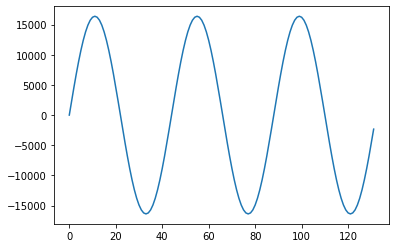

In [18]:
temp = summary[np.abs(summary['Difference (cents)']) < 5].copy()
scale = pd.concat([temp, bad_estimates]).sort_values(by='Correct frequency', axis=0).fillna(1)
waves = {}
for note in notes.split():
    waves[note] = 2**14 * np.sin(
        np.linspace(
            0, 
            scale.loc[note, 'Friendly Cycles'] * 2 * np.pi, 
            int(scale.loc[note, 'Friendly Cycles'] * scale.loc[note, 'Rounded']), 
            endpoint=False
        )
    )
for note, wave in waves.items():
    
    print(f"Wave and bytes for {note}:")
    print(wave.astype(np.int16).tobytes())
    
    plt.plot(wave)
    plt.show()

### <span style="color:red"> Exercise 4 </span> (20 pts)
What do you think of this synthesizer so far? What are some things it does well? What are some of the limitations of this design? How would you improve on it? Answer in two paragraphs.
<h3 style="background-color:lightblue"> Write Answers for Exercise 4 Below </h3>

The synth sounds pretty solid all things considered. It responds very quickly and feels pretty nice to use, although it is small and not ergonomic. 

Unfortunately you also cannot play chords on it as the code can only send a single wave at a time for now. This would be the feature I would add, providing it the capability to combine waves and output chords. I don't think it would be too hard since the structure is already there, but it may take some trial and error.

Another thing I might improve would be the ability to change types of sound waves. For example, adding square waves as a preset, or some other, more complex wave instead of just a sine wave. This would give the synth some adjustability and provide different timbres to play around with.

## <span style="color:red"> Advanced exercises </span> (Optional)

The following exercises are an opportunity to explore beyond the basic material presented above. There is not time to do all of them. Instead, pick just one of them to do for a grade. The rest can be treated as practice problems. These questions are intentionally open-ended, so you have some freedom in how you approach them. You are also welcome to work in teams of 2-3 for this exercise.

### Pick the best sample count

In order to approximate middle B, we found a rational number $\frac{134}{3}$ which was close to the desired number of samples per cycle, $\frac{22050}{440\times 2^{1/6}}$. The continued fraction expansion allows you to find a sequence of "best possible" rational approximations to any number, in the sense that each approximation is closer than any approximation with a smaller denominator. For example, we can use Sympy to generate the first several approximations to middle B.

In [20]:
import sympy
import itertools

middle_b = 22050/(440*(2**(1/sympy.S(6))))
display(sympy.Eq(middle_b, middle_b.evalf(5), evaluate=False))

best_approximations = sympy.continued_fraction_convergents(sympy.continued_fraction_iterator(middle_b))
for approx in itertools.islice(best_approximations, 6):
    display(sympy.Eq(approx, approx.evalf(5), evaluate=False))

Eq(2205*2**(5/6)/88, 44.646)

Eq(44, 44.0)

Eq(45, 45.0)

Eq(89/2, 44.5)

Eq(134/3, 44.667)

Eq(625/14, 44.643)

Eq(759/17, 44.647)

You can see that both our initial attempt (45) and our improved attempt (134/3) appear in the list.

The challenge for you is to make a software tool which does the following:

1. Computes the best rational approximations for any note, telling the error (in cents) of each approximation.
2. Produces a plot with error (in cents) on the y axis, and sample count on the x axis.
3. Makes a recommendation for which approximation to use, subject to user-specified constraints.

### Include different waveforms and octaves

Most synthesizers not only let you choose the frequency of the note you play, they also allow you to select from several waveforms. Also, synthesizers with few keys will typically provide a way to shift between octaves.

Connect some additional buttons to the Pico, and write a script to have one of them cycle between modes for different waveforms and the other cycle between modes for different octaves. When it switches modes, have the Pico print the current selection on the serial console.

## Polyphony

One unfortunate property of most synthesizers is that you can't press every key at once. That is definitely the case here, since the basic synthesizer we made only supports pressing one note at a time.

You have already designed clips for each note playing independently. Your task is to make audio clips for each pair of notes, and modify the synthesizer code so that if exactly two buttons are pressed then your two-note clip plays.